# Using Neural Networks to solve Ordinary Diferential Equations

solve following ODE using NN:
$$y' + y = 0$$
$$y(0)=1$$


## imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
from tensorflow.keras import backend as K
from tensorflow.keras.layers import concatenate

## define chebyshev function as activation function

according to chebyshev formula in the below we calculate $i$th term as activation fnction for $i$th neuron of hidden layer:

$${\displaystyle T_{n}(x)={\begin{cases}\cos(n\arccos x)&{\text{ if }}~|x|\leq 1\\\cosh(n\operatorname {arcosh} x)&{\text{ if }}~x\geq 1\\(-1)^{n}\cosh(n\operatorname {arcosh} (-x))&{\text{ if }}~x\leq -1\end{cases}}}$$

In [1]:
# defind activation functions

def chebyshev_n(x, n):
    # change domain from [0, 1] to [-1, 1]
    v = 2 * x - 1
    # i_th term of chebyshev polynomial
    return K.cast(tf.math.cos(n * tf.math.acos(v)), K.floatx())

def chebyshev_0(x):
    # change domain from [0, 1] to [-1, 1]
    v = 2 * x / 1 - 1
    # i_th term of chebyshev polynomial
    return K.cast(tf.math.cos(0 * tf.math.acos(v)), K.floatx())

def chebyshev_1(x):
    v = 2 * x / 1 - 1
    return K.cast(tf.math.cos(1 * tf.math.acos(v)), K.floatx())

def chebyshev_2(x):
    v = 2 * x / 1 - 1
    return K.cast(tf.math.cos(2 * tf.math.acos(v)), K.floatx())

def chebyshev_3(x):
    v = 2 * x / 1 - 1
    return K.cast(tf.math.cos(3 * tf.math.acos(v)), K.floatx())

def chebyshev_4(x):
    v = 2 * x / 1 - 1
    return K.cast(tf.math.cos(4 * tf.math.acos(v)), K.floatx())

## define NN structure
- input layer: one number --> shape: (1, 1)
- hidden layer: one layer with 5 neurons each neuron has different activation function
- output layer: one number --> shape: (1, 1)

In [3]:
input_layer = Input(shape=(1,))
neuron0 = Dense(units=1, activation = chebyshev_0)(input_layer)
neuron1 = Dense(units=1, activation = chebyshev_1)(input_layer)
neuron2 = Dense(units=1, activation = chebyshev_2)(input_layer)
neuron3 = Dense(units=1, activation = chebyshev_3)(input_layer)
neuron4 = Dense(units=1, activation = chebyshev_4)(input_layer)
# concat 5 neuron to make hidden layer
layer1 = concatenate([neuron0, neuron1, neuron2, neuron3, neuron4])
output = Dense(units=1, activation='linear')(layer1)

## define custome model
we need to customize loss function and training step

loss function:
    we want to solve $ y'+y=0 $ and find y so the NN's output should work in this equation.
    which means if the prediction of NN is NN(x) we should have:
    $$([NN'(x) + NN(x)] - [y'(x) + y(x)])^2 = loss$$
    and the result of above statement is our loss. we also know that $y'(x)-y(x)=0$ so we can compute loss as follow:
    $$[NN'(x) + NN(x)]^2 = loss $$

In [15]:
class CustomModel(keras.Model):

    def train_step(self, data):
        with tf.GradientTape() as tape:
            
            # Compute the loss value (came from previous code in file '1.1.ODE_sigmoid.ipyb')
            summation = []
            inf_s = np.sqrt(np.finfo(np.float32).eps) # use to calculate derivative 
            # this dor loop make train data itself (?)
            for x in np.linspace(0,1,10):
                x = np.array([x]).reshape((1, 1))
                NN_predict = self(x, training=True)
                dNN = (self(x+inf_s, training=True)-NN_predict)/inf_s 
                loss = ((dNN + NN_predict)**2)
                summation.append((dNN + self(x, training=True))**2)
            loss = tf.reduce_sum(tf.abs(summation))
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

## generate model

In [16]:
model=CustomModel(inputs=input_layer,outputs=output)

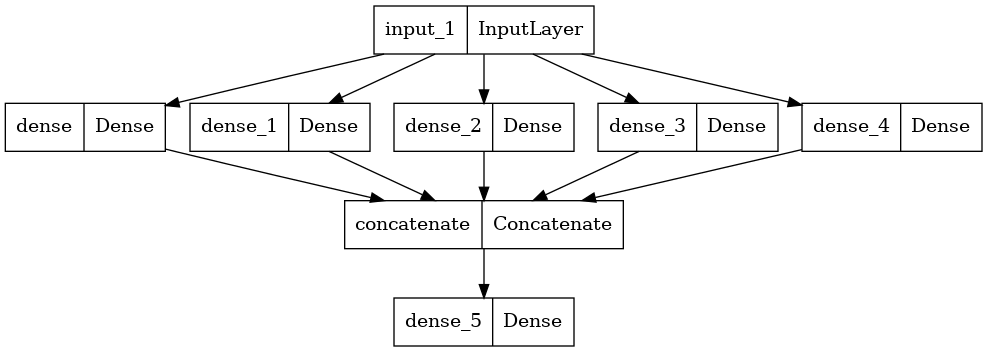

In [6]:
keras.utils.plot_model(model, "my_first_model.png")

In [7]:
model.summary()

Model: "custom_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 1)            2           ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1)            2           ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 1)            2           ['input_1[0][0]']                
                                                                                       

## compile and fit mode

In [17]:
# train data (do we actually ue them (?))
# what is our train data
x = np.linspace(0,1,10)
y = np.zeros((10, 1))

In [18]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2))
history = model.fit(x, y, batch_size=100, epochs=10)

Epoch 1/10
1/1 [==============================] - 23s 23s/step
Epoch 2/10
1/1 [==============================] - 0s 426ms/step
Epoch 3/10
1/1 [==============================] - 1s 1s/step
Epoch 4/10
1/1 [==============================] - 1s 974ms/step
Epoch 5/10
1/1 [==============================] - 1s 620ms/step
Epoch 6/10
1/1 [==============================] - 0s 122ms/step
Epoch 7/10
1/1 [==============================] - 0s 300ms/step
Epoch 8/10
1/1 [==============================] - 0s 321ms/step
Epoch 9/10
1/1 [==============================] - 0s 326ms/step
Epoch 10/10
1/1 [==============================] - 0s 219ms/step


## predict for some sample data

In [19]:
model.predict(x)

1/1 [==============================] - 1s 594ms/step


array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]], dtype=float32)

## plot the result

4/4 [==============================] - 0s 5ms/step


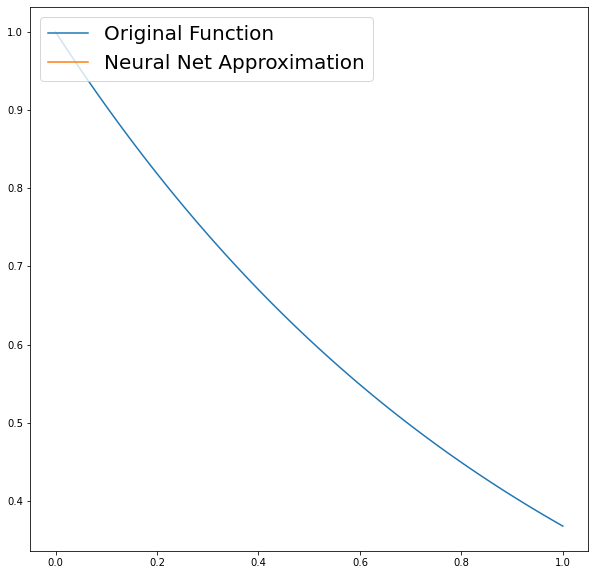

In [20]:
from matplotlib.pyplot import figure

figure(figsize=(10,10))
# True Solution (found analitically)
X = np.linspace(0, 1, 100)
S = np.exp(-X)

result = model.predict(X)

plt.plot(X, S, label="Original Function")
plt.plot(X, result, label="Neural Net Approximation")
plt.legend(loc=2, prop={'size': 20})
plt.show()